# 0. Install important libraries

In [1]:
%%capture
# Install libraries
!pip install tensorflow keras pillow numpy tqdm underthesea gensim fasttext nltk

In [2]:
print("hello")

hello


In [3]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 1. Import important libraries

In [4]:
%%capture
import os
import sys
import string
import fasttext
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from pickle import dump, load
from underthesea import word_tokenize
from gensim.utils import simple_preprocess
from collections import defaultdict

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.sequence import pad_sequences

# from keras.applications.xception import Xception, preprocess_input
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, Bidirectional, add
from keras.initializers import Constant
from keras.models import Model, load_model
from keras.utils.vis_utils import plot_model

from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical

from tqdm.notebook import tqdm
from nltk.translate.bleu_score import corpus_bleu

# 2. Getting and performing data cleaning

In [5]:
def load_doc(filename):
    file = open(filename, 'r', encoding='utf-8')
    text = file.read()
    file.close()
    
    return text

In [6]:
def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions = defaultdict()
    for caption in captions[:-1]:
        img, cap = caption.split('\t')
        if img not in descriptions:
            descriptions[img] = [cap]
        else:
            descriptions[img].append(cap)
    return descriptions

In [7]:
def cleaning_text(descriptions):
    table = str.maketrans('', '', string.punctuation)
    for img, captions in descriptions.items():
        for idx, cap in enumerate(captions):
            desc = cap.replace(' - ', ' ').translate(table)
            desc = ' '.join(simple_preprocess(desc))
            desc = word_tokenize(desc, format='text')
            
            descriptions[img][idx] = desc
    return descriptions

In [8]:
def text_vocabulary(descriptions):
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(desc.split()) for desc in descriptions[key]]
    
    return vocab

In [9]:
def save_descriptions(descriptions, filename):
    lines = list()
    for key, captions in descriptions.items():
        for cap in captions:
            lines.append(key + '\t' + cap)
    data = '\n'.join(lines)
    file = open(filename, 'w', encoding='utf-8')
    file.write(data)
    file.close()

In [10]:
dataset_text = '../input/flickr8k-vi-caps'
dataset_images = '../input/flickr8k/Images'
sample_image = '2423292784_166ee54e0b.jpg'

text_file = dataset_text + '/' + 'captions_vi.txt'

In [11]:
descriptions = all_img_captions(text_file)
print('Length of descriptions:', len(descriptions))
print('Description before clean text')
descriptions[sample_image]

Length of descriptions: 8000
Description before clean text


['Một cậu bé với một cái chao kim loại trên đầu ',
 ' Một chú hề nhỏ với chiếc chao trên đầu',
 ' Một cậu bé điên có một cái bát trên đầu',
 ' Một cậu bé đội một chiếc chao kim loại trên đầu',
 ' Cậu bé mặc áo sơ mi sọc này đang đặt một cái rây trên đầu']

In [12]:
clean_descriptions = cleaning_text(descriptions)
print('Descriptions after clean text')
clean_descriptions[sample_image]

Descriptions after clean text


['một cậu bé với một cái chao kim_loại trên đầu',
 'một chú hề nhỏ với chiếc chao trên đầu',
 'một cậu bé điên có một cái bát trên đầu',
 'một cậu bé đội một chiếc chao kim_loại trên đầu',
 'cậu bé mặc áo sơ_mi sọc này đang đặt một cái rây trên đầu']

In [13]:
vocab = text_vocabulary(clean_descriptions)
print('Length of vocabuary:', len(vocab))

Length of vocabuary: 5562


In [14]:
save_descriptions(clean_descriptions, 'descriptions.txt')

# 3. Extract feature vector from all images

In [15]:
def extract_feature(directory):
    model = InceptionV3(weights='imagenet')
    model = Model(model.input, model.layers[-2].output)
    
    features = dict()
    for img in tqdm(os.listdir(directory), file=sys.stdout):
        filename = directory + '/' + img
        image = load_img(filename, target_size=(299, 299))
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)
        
        feature = model.predict(image, verbose=0)
        features[img] = feature
    return features

In [16]:
features = extract_feature(dataset_images)
dump(features, open('features_inception_v3.pkl', 'wb'))

96124928/96112376 [==============================] - 3s 0us/step


  0%|          | 0/8091 [00:00<?, ?it/s]

In [17]:
feature_path = 'features_inception_v3.pkl'
features = load(open(feature_path, 'rb'))

In [18]:
features[sample_image]

array([[0.10134819, 0.17562562, 0.00392631, ..., 0.91039944, 0.31022805,
        0.23347566]], dtype=float32)

# 4. Loading dataset for training the model

In [19]:
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split('\n')
    return photos

In [20]:
def load_descriptions(filename, photos):
    file = load_doc(filename)
    descriptions = dict()
    for line in file.split('\n'):
        line = line.split('\t')
        
        if len(line) < 1:
            continue
            
        image, cap = line[0], line[1]
        if image in photos:
            if image not in descriptions:
                descriptions[image] = list()
            desc = 'startseq ' + cap + ' endseq'
            descriptions[image].append(desc)
    return descriptions

In [21]:
def load_features(photos):
    all_features = load(open(feature_path, 'rb'))
    features = {img: all_features[img] for img in photos}
    return features

In [22]:
train_imgs = load_photos(dataset_text + '/' + 'trainImages.txt')
train_descriptions = load_descriptions('descriptions.txt', train_imgs)
train_features = load_features(train_imgs)

test_imgs = load_photos(dataset_text + '/' + 'testImages.txt')
test_descriptions = load_descriptions('descriptions.txt', test_imgs)
test_features = load_features(test_imgs)

# 5. Tokenizing the vocabulary and word embedding

In [23]:
def dict_to_list(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(desc) for desc in descriptions[key]]
    return all_desc

In [24]:
def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    oov_token = 'unk'
    tokenizer = Tokenizer(oov_token=oov_token)
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

In [25]:
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.pkl', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
print('# vocabulary:', vocab_size)

# vocabulary: 3299


In [26]:
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(desc.split()) for desc in desc_list)
max_length = max_length(descriptions)
print('Max length of train set:', max_length)

Max length of train set: 41


In [27]:
def create_embedding_matrix(vocab):
    embedding_index = fasttext.load_model('../input/fasttext-vietnamese-word-vectors-full/cc.vi.300.bin')
    
    embedding_dim = 300
    hits = 0
    misses = 0
    vocab_size = len(vocab) + 1
    
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, idx in vocab.items():
        embedding_vector = embedding_index[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))
    
    return embedding_matrix

In [28]:
%%capture --no-stdout
vocab = tokenizer.word_index
embedding_matrix = create_embedding_matrix(vocab)
print(embedding_matrix.shape)

Converted 3298 words (0 misses)
(3299, 300)


# 6. Create data generator

In [29]:
def data_generator(descriptions, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    
    while True:
        for key, captions in descriptions.items():
            n += 1
            feature = features[key][0]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [30]:
[a, b], c = next(data_generator(train_descriptions, features, tokenizer, max_length, vocab_size, 32))
a.shape, b.shape, c.shape

((2356, 2048), (2356, 41), (2356, 3299))

# 7. Defining the CNN-RNN model

In [31]:
def define_model(vocab_size, max_length):
    embedding_dim = 300
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(
        vocab_size,
        embedding_dim,
        embeddings_initializer=Constant(embedding_matrix),
        mask_zero=True,
        trainable=False,
    )(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = Bidirectional(LSTM(128))(se2)

    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001))

    print(model.summary())
#     plot_model(model, to_file='model.png', show_shapes=True)

    return model

# 8. Training the model

In [32]:
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

model = define_model(vocab_size, max_length)
epochs = 50
batch_size = 32
steps = len(train_imgs) // batch_size

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 3299
Description Length:  41
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 41)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 41, 300)      989700      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]      

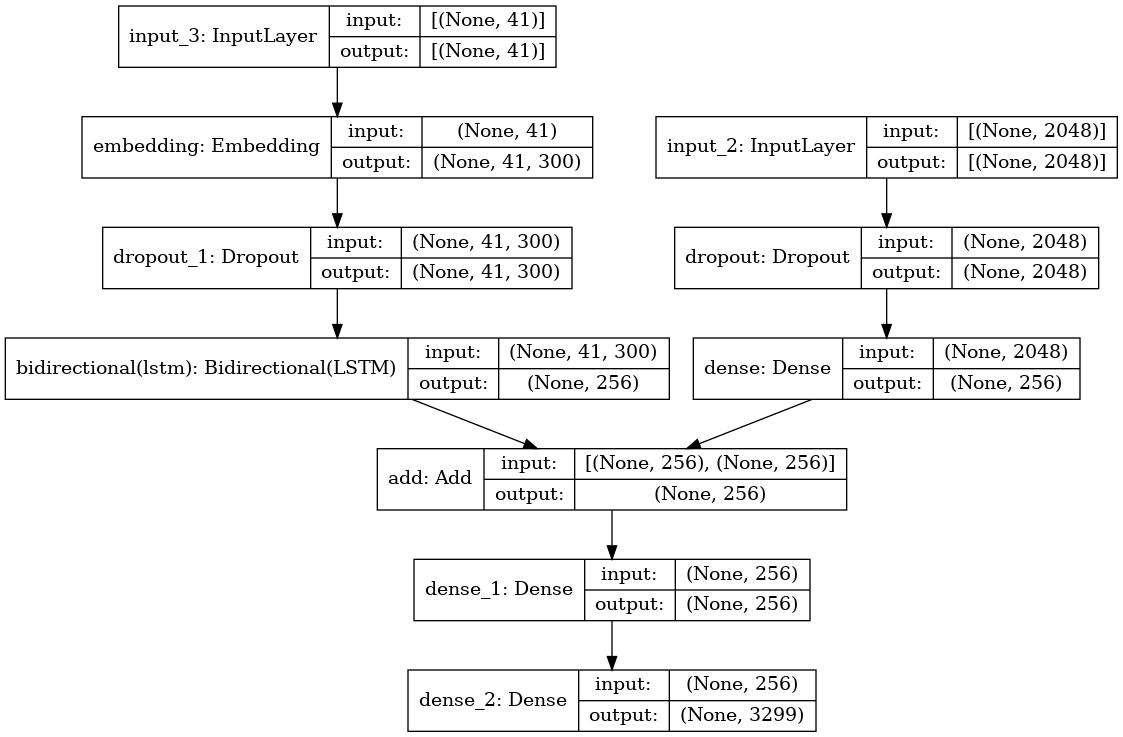

In [33]:
# Plot the model
plot_model(model, to_file="model.png", show_shapes=True)

In [34]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)



187/187 [==============================] - 53s 285ms/step - loss: 2.7496


In [35]:
model.save("best_model.h5")

In [36]:
# Load model
model.load_weights("best_model.h5")

# 9. Generate captions for the image

In [37]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [38]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        seq = tokenizer.texts_to_sequences([in_text])[0]
        seq = pad_sequences([seq], maxlen=max_length)
        yhat = model.predict([image, seq], verbose=0)
        pred_ids = np.argmax(yhat)
        word = idx_to_word(pred_ids, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text

In [39]:
model = load_model('./best_model.h5')
actual, predicted = list(), list()

for image in tqdm(test_imgs):
    captions = test_descriptions[image]
    actual_captions = [caption.split() for caption in captions]

    y_pred = predict_caption(model, test_features[image], tokenizer, max_length)
    y_pred = y_pred.split()

    actual.append(actual_captions)
    predicted.append(y_pred)

# BLEU score
print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/2000 [00:00<?, ?it/s]

BLEU-1: 0.486039
BLEU-1: 0.343102


In [40]:
print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

BLEU-3: 0.283986
BLEU-4: 0.177759


# 10. Visualize the results

In [41]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):
    image_path = os.path.join(dataset_images, image_name)
    image = Image.open(image_path)
    descriptions = load_descriptions('descriptions.txt', train_imgs + test_imgs)
    captions = descriptions[image_name]
    print('-' * 20 + 'Actual' + '-' * 20)
    for caption in captions:
        print(caption)
    y_pred = predict_caption(model, features[image_name], tokenizer, max_length)
    print('-' * 20 + 'Predicted' + '-' * 20)
    print(y_pred)
    plt.imshow(image)

1685463722_55843b6d3c.jpg
--------------------Actual--------------------
startseq một người phụ_nữ và hai con chó của cô đang đi trên đường endseq
startseq một người phụ_nữ mặc quần short bị cắt đi xuống phố với một con chó endseq
startseq người phụ_nữ mặc quần short màu xanh và áo vest màu nâu có một con chó đen bên phải của cô ấy và một con chó phía sau cô ấy endseq
startseq người phụ_nữ đang dắt chó đi dạo endseq
startseq người phụ_nữ và con chó đen nhỏ đi ngang vỉa_hè endseq
--------------------Predicted--------------------
startseq một cô gái trẻ chạy trên đường đường endseq


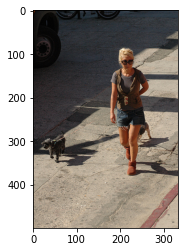

In [42]:
from random import sample

image_name = sample(train_imgs, 1)[0]
print(image_name)
generate_caption(image_name)

In [43]:
# Save model
# model.save("best_model.h5")

In [44]:
# Load model
# from tensorflow.keras.models import load_model
# model.load_weights("../input/filck8khoangchi/best_model.h5")